# Decision Tree Regression
<hr>
<br>

**`Standart Devation`**

<Br>
$Std = \sqrt{\dfrac{\sum{ (x-myu)^2}} {n}}$
<br>
    <br>
$myu = \dfrac{\sum{x}}{n}$
<br>
<hr>
<br>
    
**`Standart Devation Reduction`**
<br>
<br>
$SDTR = STD(Label) - STD(Feature, Label)$
    

In [1]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
data = pd.read_csv("Datasets/DTree.csv")
data

,Ob-Havo,Temp,Namlik,Shamol,Oyinchilar
0,Yomg'ir,Issiq,Yuqori,False,25
1,Yomg'ir,Issiq,Yuqori,True,30
2,Bulutli,Issiq,Yuqori,False,46
3,Quyoshli,Yaxshi,Yuqori,False,45
4,Quyoshli,Salqin,Normal,False,52
5,Quyoshli,Salqin,Normal,True,23
6,Bulutli,Salqin,Normal,True,43
7,Yomg'ir,Yaxshi,Yuqori,False,35
8,Yomg'ir,Salqin,Normal,False,38
9,Quyoshli,Yaxshi,Normal,False,46


In [3]:
def std(arr):
    myu = arr.mean()
    return np.sqrt(np.sum(np.square(arr - myu))/ len(arr))

In [4]:
std(data['Oyinchilar'].values)

9.321086474291743

In [9]:
def stdr(arr1,arr2):
    std_arr = std(arr2)
    uniq = np.unique(arr1)
    list_stdr = list()
    for i in uniq:
        label = arr2[arr1==i]
        print(i,":", std(label), "\t",len(label))
        list_stdr.append([len(label), std(label)])
    list_stdr = np.array(list_stdr).T
    
    return std_arr - np.dot(list_stdr[0]/len(arr1), list_stdr[1])
    


In [10]:
obhavo = stdr(data['Ob-Havo'].values, data['Oyinchilar'].values)
print("STDR(Ob-havo) : ", obhavo)

Bulutli : 3.491060010942235 	 4
Quyoshli : 10.870142593360953 	 5
Yomg'ir : 7.782030583337487 	 5
STDR(Ob-havo) :  1.6621503366302326


In [11]:
temp = stdr(data['Temp'].values, data['Oyinchilar'].values)
print("STDR(Temp) : ", temp)

Issiq : 8.954747344286158 	 4
Salqin : 10.51189802081432 	 4
Yaxshi : 7.6521601888326645 	 6
STDR(Temp) :  0.4796905747633211


In [12]:
namlik = stdr(data['Namlik'].values, data['Oyinchilar'].values)
print("STDR(Namlik) : ", namlik)

Normal : 8.734169352933014 	 7
Yuqori : 9.363411204670822 	 7
STDR(Namlik) :  0.272296195489826


In [13]:
shamol = stdr(data['Shamol'].values, data['Oyinchilar'].values)
print("STDR(Shamol) : ", temp)

False : 7.873015622999868 	 8
True : 10.593499054713803 	 6
STDR(Shamol) :  0.4796905747633211


In [18]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Decision Tree Classification
<hr>
<br>

**`Entropy`**

$E(S) = \sum_{i=1}^n - p_i log_2 p_i$

<hr>
<br>

**`Information Gain`**
<br>
$Gain(S,A) = E(S) - \sum_{(v Values(A))}  \dfrac{S}{S_v} E(S_v)  $

<hr>
<br>

**`Gini Index`**

$Gini = 1 - \sum_{i=1}^j p_i^2$


In [19]:
data = pd.read_csv("Datasets/DTree.csv")
data
arr = np.array([1,1,1,1,1,0,1,0,0,1,1,0,0,0])
data['Oyinchilar'] = arr

In [20]:
def compute_impurity(feature, criteria="entropy"):
    """
    Supported impurity criteria: "entropy", "gini"
    """
    probs = np.unique(feature, return_counts=True)[1] 
    probs = probs / len(feature)
    
    if criteria=="entropy":
        return -1 * np.sum(np.log2(probs) * probs )
    
    elif criteria=="gini":
        
        return 1 - np.sum(np.square(probs))
    
    else:
        raise ValueError("Unkown criteria")

In [21]:
compute_impurity(arr)

0.9852281360342515

In [22]:
def information_gain(data, target,  split_criterion="entropy"):
    entropy_list = list()
    weight_list = list()
    target_entropy = compute_impurity(target, split_criterion)   
    for i in np.unique(data):
        
        label = target[data == i]
        
        
        entropy = compute_impurity(feature=label,  criteria=split_criterion)
        
        
        entropy_list.append( entropy )
        weight_list.append(len(label)/len(data))
   
    information_gain = target_entropy - np.sum(np.array(entropy_list) * weight_list)
    return information_gain
        

In [23]:
information_gain(data['Ob-Havo'].values, data['Oyinchilar'].values,  split_criterion="entropy")

0.0059777114237740125

In [24]:
information_gain(data['Temp'].values, data['Oyinchilar'].values,  split_criterion="entropy")

0.03914867190307081

In [25]:
information_gain(data['Namlik'].values, data['Oyinchilar'].values,  split_criterion="entropy")

0.0

In [26]:
information_gain(data['Shamol'].values, data['Oyinchilar'].values,  split_criterion="entropy")

0.011265848648557175

In [27]:
X = data.drop('Oyinchilar', axis=1).values
X

array([["Yomg'ir", 'Issiq', 'Yuqori', False],
       ["Yomg'ir", 'Issiq', 'Yuqori', True],
       ['Bulutli', 'Issiq', 'Yuqori', False],
       ['Quyoshli', 'Yaxshi', 'Yuqori', False],
       ['Quyoshli', 'Salqin', 'Normal', False],
       ['Quyoshli', 'Salqin', 'Normal', True],
       ['Bulutli', 'Salqin', 'Normal', True],
       ["Yomg'ir", 'Yaxshi', 'Yuqori', False],
       ["Yomg'ir", 'Salqin', 'Normal', False],
       ['Quyoshli', 'Yaxshi', 'Normal', False],
       ["Yomg'ir", 'Yaxshi', 'Normal', True],
       ['Bulutli', 'Yaxshi', 'Yuqori', True],
       ['Bulutli', 'Issiq', 'Normal', False],
       ['Quyoshli', 'Yaxshi', 'Yuqori', True]], dtype=object)

In [45]:
ordinal = OrdinalEncoder()

In [46]:
X = ordinal.fit_transform(X)

In [47]:
X

array([[2., 0., 1., 0.],
       [2., 0., 1., 1.],
       [0., 0., 1., 0.],
       [1., 2., 1., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 1.],
       [0., 1., 0., 1.],
       [2., 2., 1., 0.],
       [2., 1., 0., 0.],
       [1., 2., 0., 0.],
       [2., 2., 0., 1.],
       [0., 2., 1., 1.],
       [0., 0., 0., 0.],
       [1., 2., 1., 1.]])

In [31]:
y = data['Oyinchilar'].values
y

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0])

class DecisionTreeClassifier:
    def __init__(self, min_sample_split=2, max_depth = 2):
        # Asosiy tugun
        self.root = None
        
        # To'xtash shartlari
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        
        X, Y = dataset[:,:-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)
        
        # To'xtash shartlari bajarilmaguncha bo'lish
        if num_samples >= self.min_sample_split and curr_depth <= self.max_depth:
            # Eng yaxshi bo'linishni topish
            best_split = self.get_best_split(dataset, num_samples, num_features)
            
            # bolinishning info_gain musbatlikka tekshiryapmiz
            if best_split["info_gain"]>0:
                # chap tomonini bo'linishlarini topamiz
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                
                # ong tomonini bo'linishlarini topamiz
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                
                # Daraxt tugunini qaytaramiz
                return Node(best_split["feature_index"], best_split["treshold"], left_subtree, right_subtree, best_split["info_gain"])
            
        # Agar bo'linish sharti to'g'ri kelmasa oxirgi bargni qaytaramiz
        leaf_value = self.calculate_leaf_value(Y)
        
        # Bargni qaytaramiz
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
            
        # Eng yaxshi bo'linishni saqlash uchun dict yaratamiz
        best_split = dict()
        max_info_gain = - float('inf')
        
        # Har bir feature ni korib chiqamiz
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_treshold = np.unique(feature_values)
            
            # Datadagi eng yaxshi bo'linish shartini topamiz ya'ni chegarani
            
            for treshold in possible_treshold:
                
                # joriy chegara bo'yicha bo'lamiz                
                dataset_left, dataset_right = self.split(dataset, feature_index, treshold)
                
                # Bo'lingan datasetni not null ga tekshiryapmiz
                if len(dataset_left)>0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:,-1]
                    
                    # info gain ni hisoblaymiz
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    
                    # best_split dictni yangilaymiz
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["treshold"]  = treshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        
        return best_split    
    
    
    def split(self, dataset, feature_index, treshold):
        """Datani chegara bo'yicha bo'lish"""
        dataset_left = np.array([row for row in dataset if row[feature_index]<=treshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]<treshold])
        
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode = "entropy"):
        """Info gain ni hisoblash"""
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == "gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        elif mode == "entropy":
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))
        else:
            assert "ValueError"
            
        
        return gain
    
    def entropy(self, y):
        """Entropy ni topish funksiyasi"""
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y==cls]) / len(y)
            entropy += - p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        """Gini index ni topish funksiyasi"""
        
        class_labels = np.unique(y)        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
    
    def calculate_leaf_value(self, y):
        """Barg tugunini hisoblash funksiyasi"""
        
        y_list = [i for i in y]
        return max(y_list, key=y_list.count)
    
    def print_tree(self, tree=None, indent = " "):
        """Decision Tree ni chiqarish funksiyasi"""
        
        if not tree:
            tree = self.root
            
        if tree.value is not None:
            print(tree.value)
        
        else:
            print("X_" + str(tree.feature_index), "<=", tree.treshold, "?", tree.info_gain)
            print(f"{indent}left : ", end="")
            self.print_tree(tree.left, indent+indent)
            print(f"{indent}right : " ,end="")
            self.print_tree(tree.right, indent=indent+indent)
            
    def fit(self, x, y):
        """Decision Tree ni oqitish funksiyasi"""
        
        dataset = np.concatenate((x, y), axis=1)
        self.root = self.build_tree(dataset)
        
    def predict(self, x):
        """Predict funksiyasi"""
        
        preditions = [self.make_prediction(i, self.root) for i in x]
        return preditions
    
    def make_prediction(self, x, tree):
        """Bitta ma'lumotni predict qilish funksiyasi"""
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.treshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)      

In [119]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # Oxirgi chiqish qiymati uchun
        self.value = value

In [93]:
class CustomDecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=5):
        ''' constructor '''
        
        # Bosh tugunni istalizatsiya qilish
        self.root = None
        
        # Bo'linish chegarasi bilan maksimal chuqurlik
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' Daraxtni qurish uchun rekursiv funksiya''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # To'tatish shartlari bajarilmaguncha bo'linadi
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # Eng yaxshi bo'linishni topish funksiyasi
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # Info gain ni musbatlikka tekshiryapmiz
            if best_split["info_gain"]>0:
                # chapga bo'linish
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # onga bo'linish
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # Daraxt tugunlarini qaytaradi
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # Chiquvchi qiymatnin hisoblash funksiyasi
        leaf_value = self.calculate_leaf_value(Y)
        # Chiquvchi qiymatni qaytaradi
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' Eng yaxshi bo'linishni topish funksiyasi '''
        
        # Bo'linishni saqlash uchun fuksiya
        best_split = {}
        max_info_gain = -float("inf")
        
        # Barcha feature ni tekshirish
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            print (possible_thresholds)
            # Eng yaxshi bo'linishni topish
            for threshold in possible_thresholds:
                # Chegara bo'yicha bo'linishlarni olish
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # Bo'lingan datalarni tekshirish
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [94]:
my_tree = CustomDecisionTreeClassifier()

In [95]:
X

array([[2., 0., 1., 0.],
       [2., 0., 1., 1.],
       [0., 0., 1., 0.],
       [1., 2., 1., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 1.],
       [0., 1., 0., 1.],
       [2., 2., 1., 0.],
       [2., 1., 0., 0.],
       [1., 2., 0., 0.],
       [2., 2., 0., 1.],
       [0., 2., 1., 1.],
       [0., 0., 0., 0.],
       [1., 2., 1., 1.]])

In [96]:
y

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0])

In [97]:
Y = data.iloc[:,-1].values.reshape(-1,1)
Y

array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0]])

In [98]:
my_tree.fit(X, Y)

In [99]:
data

,Ob-Havo,Temp,Namlik,Shamol,Oyinchilar
0,Yomg'ir,Issiq,Yuqori,False,1
1,Yomg'ir,Issiq,Yuqori,True,1
2,Bulutli,Issiq,Yuqori,False,1
3,Quyoshli,Yaxshi,Yuqori,False,1
4,Quyoshli,Salqin,Normal,False,1
5,Quyoshli,Salqin,Normal,True,0
6,Bulutli,Salqin,Normal,True,1
7,Yomg'ir,Yaxshi,Yuqori,False,0
8,Yomg'ir,Salqin,Normal,False,0
9,Quyoshli,Yaxshi,Normal,False,1


In [100]:
my_tree.print_tree()

X_1 <= 0.0 ? 0.025510204081632737
 left:X_2 <= 0.0 ? 0.375
  left:0.0
  right:1.0
 right:X_2 <= 0.0 ? 0.08333333333333331
  left:X_1 <= 1.0 ? 0.1111111111111111
    left:X_0 <= 0.0 ? 0.16666666666666669
        left:1.0
        right:X_0 <= 1.0 ? 0.1111111111111111
                left:X_3 <= 0.0 ? 0.5
                                left:1.0
                                right:0.0
                right:0.0
    right:1.0
  right:X_3 <= 0.0 ? 0.125
    left:X_0 <= 1.0 ? 0.5
        left:1.0
        right:0.0
    right:0.0


In [101]:
sk_tree = DecisionTreeClassifier(max_depth=5)

In [102]:
sk_tree.fit(X, Y)

DecisionTreeClassifier(max_depth=5)

In [118]:
sk_tree.predict([[2., 0., 0., 0.]])

array([0])

In [116]:
my_tree.predict([[0., 0., 0., 0.]])

[0.0]

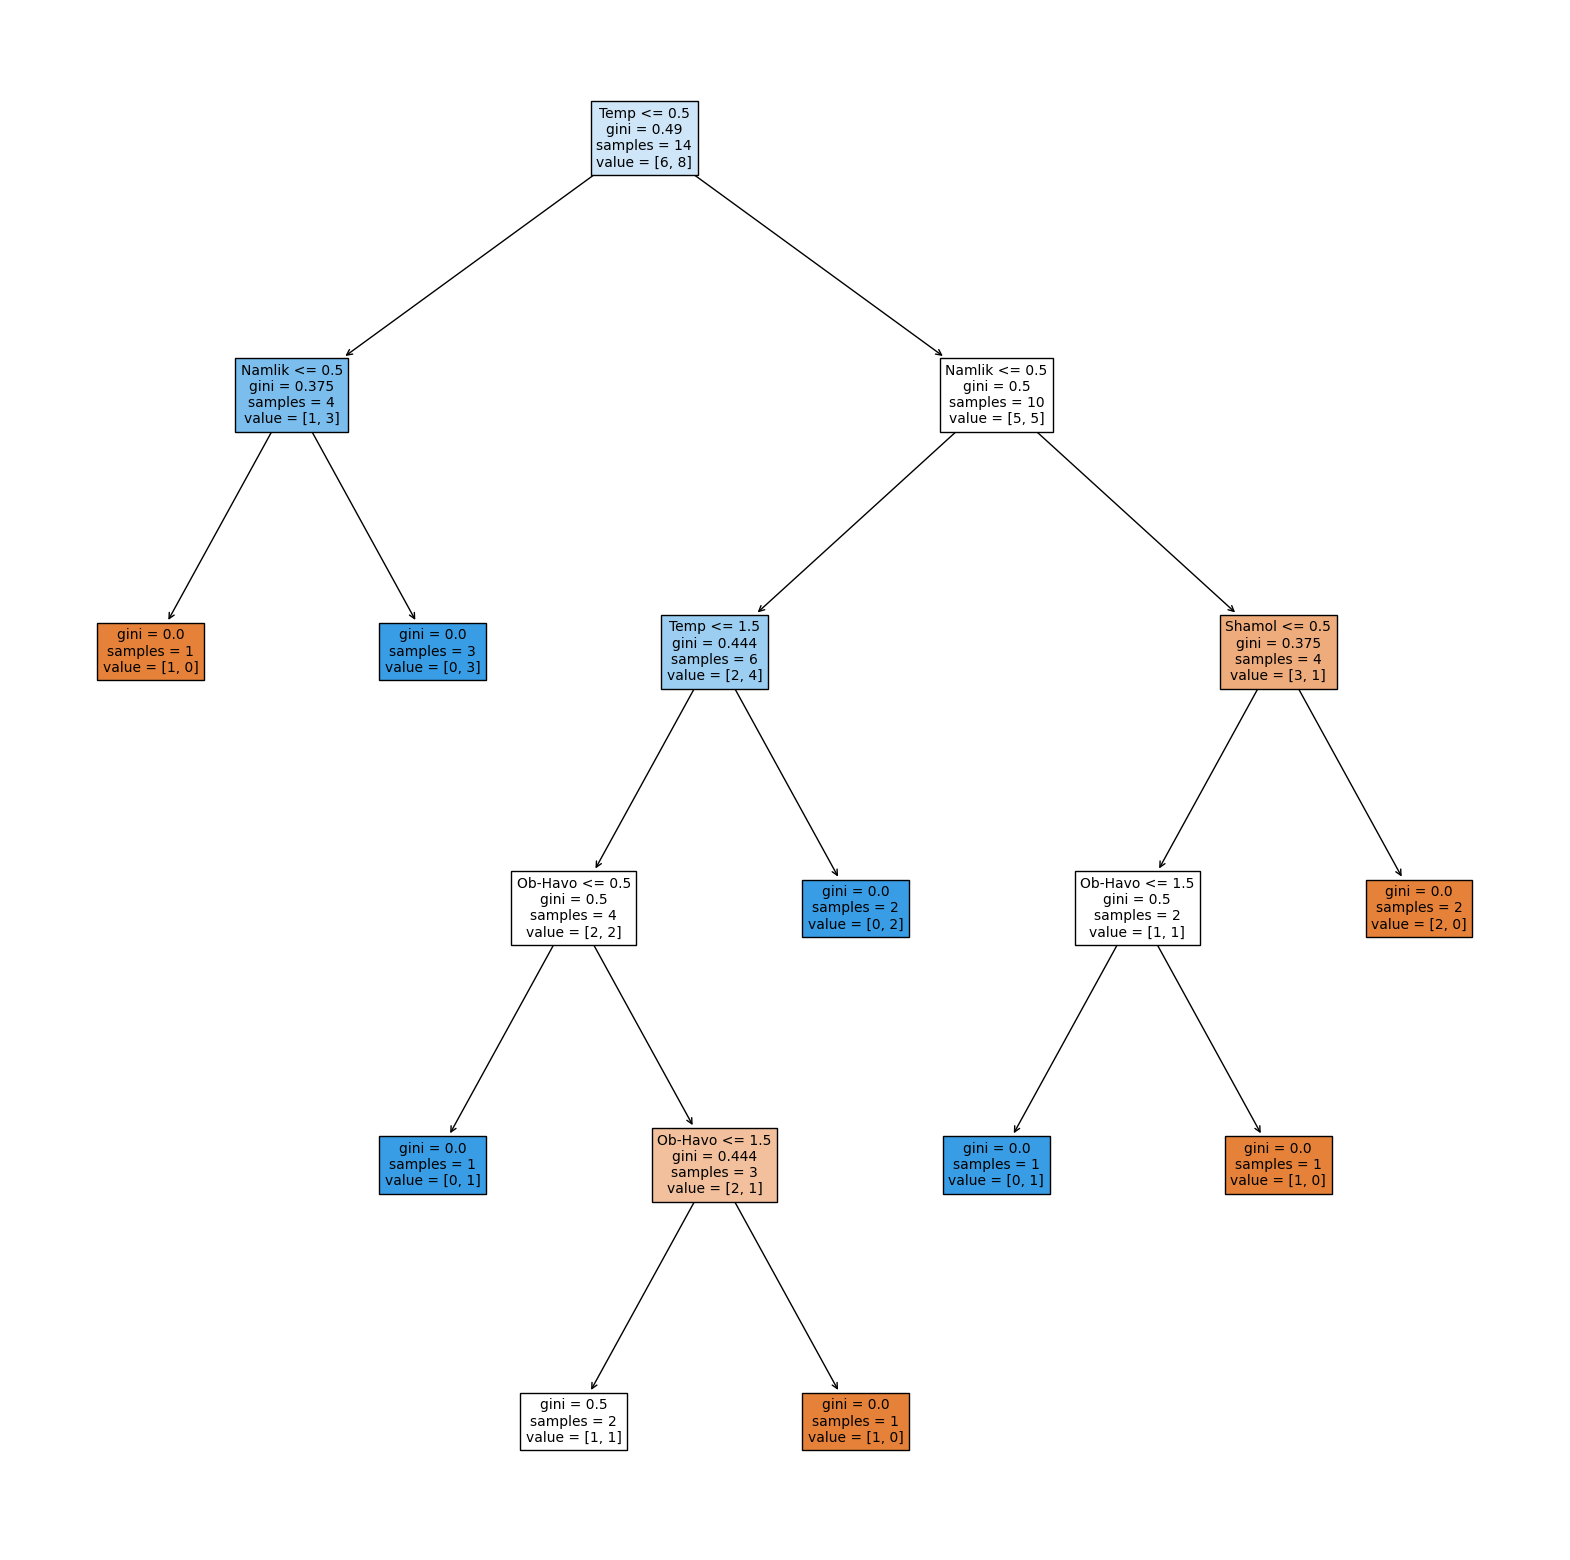

In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plot_tree(sk_tree,filled=True,fontsize=10,feature_names=data.columns)
plt.show()